# Trainable Wavelet Fusion Model - Testing and Evaluation

This notebook tests the trained wavelet fusion model on sample CT-MRI image pairs and evaluates the fusion quality with comprehensive metrics and visualizations.

## 1. Import Required Libraries

In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import seaborn as sns
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

# PyWavelets and pytorch_wavelets for wavelet transforms
from pytorch_wavelets import DWTForward, DWTInverse

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set matplotlib style
plt.style.use('default')
sns.set_palette("husl")

Using device: cuda


## 2. Load the Trained Model

Define the model architecture and load the trained weights.

In [3]:
# Load the trained model
model_path = 'checkpoints_wavelet/wavelet_fusion_best.pt'
if os.path.exists(model_path):
    model = WaveletFusionNet(wave='haar').to(device)
    
    # Load checkpoint which contains model, optimizer, and config
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract model state_dict from checkpoint
    if isinstance(checkpoint, dict) and 'model' in checkpoint:
        model.load_state_dict(checkpoint['model'])
        print(f"Model loaded successfully from {model_path}")
        
        # Display checkpoint info if available
        if 'cfg' in checkpoint:
            print(f"Training config: {checkpoint['cfg']}")
    else:
        # If checkpoint is just the state_dict directly
        model.load_state_dict(checkpoint)
        print(f"Model loaded successfully from {model_path}")
    
    model.eval()
    
    # Display learned parameters
    print(f"\nLearned Fusion Weights:")
    print(f"  Low-frequency (α_L):  {model.alpha_low.item():.4f}")
    print(f"  LH detail (α_LH):     {model.alpha_lh.item():.4f}")
    print(f"  HL detail (α_HL):     {model.alpha_hl.item():.4f}")
    print(f"  HH detail (α_HH):     {model.alpha_hh.item():.4f}")
else:
    print(f"Model checkpoint not found at {model_path}. Please train the model first.")
    model = None

Model loaded successfully from checkpoints_wavelet/wavelet_fusion_best.pt
Training config: {'ct_dir': 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/CT', 'mri_dir': 'Harvard-Medical-Image-Fusion-Datasets/MyDatasets/CT-MRI/train/MRI', 'save_dir': 'checkpoints_wavelet', 'resize': None, 'batch_size': 4, 'epochs': 20, 'lr': 0.001, 'val_split': 0.1, 'wave': 'haar', 'w_ssim': 1.0, 'w_grad': 1.0, 'w_perc': 0.1}

Learned Fusion Weights:
  Low-frequency (α_L):  0.6723
  LH detail (α_LH):     0.6540
  HL detail (α_HL):     0.5000
  HH detail (α_HH):     0.5000


## 3. Load and Preprocess Test Images

Define helper functions to load and preprocess CT-MRI image pairs.

In [4]:
def load_image_pair(ct_path, mri_path, resize=None):
    """Load and preprocess a CT-MRI image pair."""
    ct = cv2.imread(ct_path, cv2.IMREAD_GRAYSCALE)
    mri = cv2.imread(mri_path, cv2.IMREAD_GRAYSCALE)
    
    if ct is None or mri is None:
        raise FileNotFoundError(f"Could not load images: {ct_path}, {mri_path}")
    
    if resize is not None:
        H, W = resize
        ct = cv2.resize(ct, (W, H), interpolation=cv2.INTER_AREA)
        mri = cv2.resize(mri, (W, H), interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1]
    ct = ct.astype(np.float32)
    mri = mri.astype(np.float32)
    if ct.max() > 1.0: ct /= 255.0
    if mri.max() > 1.0: mri /= 255.0
    
    return ct, mri

def get_test_image_pairs(ct_dir, mri_dir, num_samples=5):
    """Get a list of test image pairs."""
    ct_files = sorted(glob.glob(os.path.join(ct_dir, '*.png')))
    mri_files = sorted(glob.glob(os.path.join(mri_dir, '*.png')))
    
    # Match files by basename
    pairs = []
    for ct_file in ct_files:
        ct_basename = os.path.basename(ct_file)
        mri_file = os.path.join(mri_dir, ct_basename)
        if os.path.exists(mri_file):
            pairs.append((ct_file, mri_file))
    
    # Select a subset for testing
    if len(pairs) > num_samples:
        # Select evenly spaced samples
        indices = np.linspace(0, len(pairs)-1, num_samples, dtype=int)
        pairs = [pairs[i] for i in indices]
    
    return pairs

# Get test image pairs
ct_test_dir = 'Harvard-Medical-Image-Fusion-Datasets/CT-MRI/CT'
mri_test_dir = 'Harvard-Medical-Image-Fusion-Datasets/CT-MRI/MRI'

test_pairs = get_test_image_pairs(ct_test_dir, mri_test_dir, num_samples=6)
print(f"Found {len(test_pairs)} test image pairs")

for i, (ct_path, mri_path) in enumerate(test_pairs[:3]):
    print(f"  Pair {i+1}: {os.path.basename(ct_path)}")

Found 6 test image pairs
  Pair 1: 16003.png
  Pair 2: 2004.png
  Pair 3: 28006.png


## 4. Perform Image Fusion

Define fusion methods including the trained model and baseline methods for comparison.

In [5]:
def fuse_with_model(model, ct, mri):
    """Fuse images using the trained model."""
    if model is None:
        return None
    
    with torch.no_grad():
        # Convert to tensors and add batch dimension
        ct_tensor = torch.from_numpy(ct)[None, None, ...].to(device)  # (1,1,H,W)
        mri_tensor = torch.from_numpy(mri)[None, None, ...].to(device)
        
        # Perform fusion
        fused_tensor = model(ct_tensor, mri_tensor)
        
        # Convert back to numpy
        fused = fused_tensor.squeeze().cpu().numpy()
        return np.clip(fused, 0, 1)

def fuse_average(ct, mri):
    """Simple average fusion."""
    return 0.5 * (ct + mri)

def fuse_max(ct, mri):
    """Max-based fusion."""
    return np.maximum(ct, mri)

def fuse_weighted(ct, mri, weight=0.6):
    """Weighted fusion favoring CT."""
    return weight * ct + (1 - weight) * mri

# Test fusion on the first image pair
if test_pairs and model is not None:
    ct_path, mri_path = test_pairs[0]
    ct_img, mri_img = load_image_pair(ct_path, mri_path)
    
    print(f"Testing fusion on: {os.path.basename(ct_path)}")
    print(f"Image shape: {ct_img.shape}")
    print(f"CT range: [{ct_img.min():.3f}, {ct_img.max():.3f}]")
    print(f"MRI range: [{mri_img.min():.3f}, {mri_img.max():.3f}]")
    
    # Test fusion
    fused_model = fuse_with_model(model, ct_img, mri_img)
    if fused_model is not None:
        print(f"Fused range: [{fused_model.min():.3f}, {fused_model.max():.3f}]")
        print("Fusion successful!")
    else:
        print("Model fusion failed")

Testing fusion on: 16003.png
Image shape: (256, 256)
CT range: [0.000, 1.000]
MRI range: [0.000, 0.788]
Fused range: [0.000, 0.868]
Fusion successful!


## 5. Display Fusion Results

Visualize the fusion results for individual image pairs.

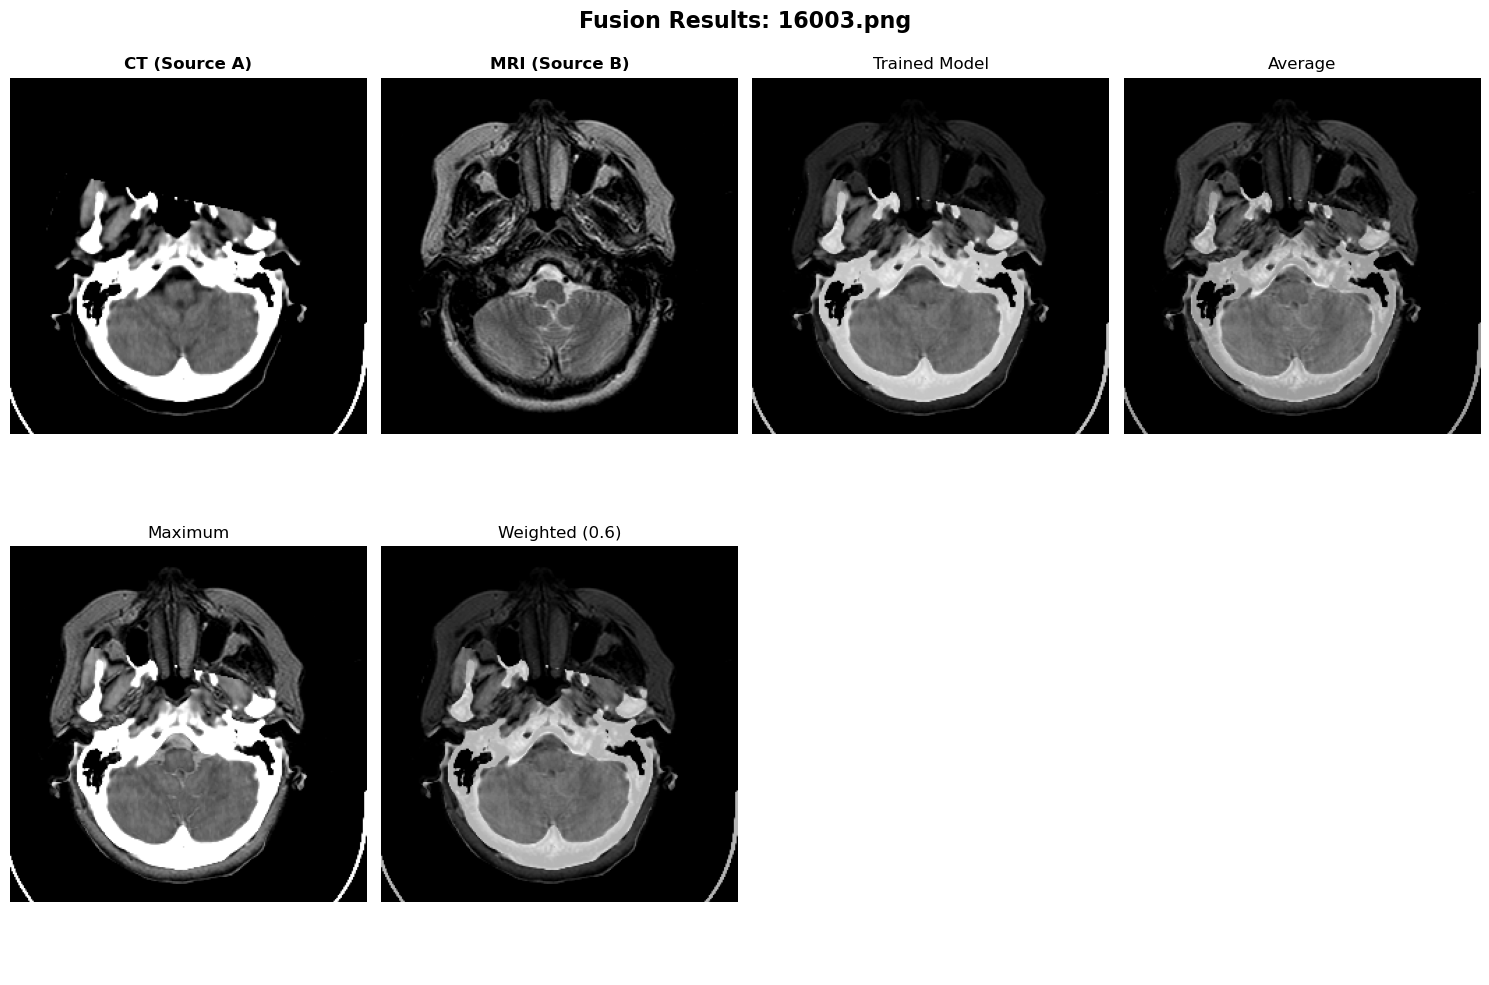

In [6]:
def display_fusion_results(ct, mri, fused_results, titles, figsize=(15, 10)):
    """Display original images and fusion results."""
    n_methods = len(fused_results)
    n_cols = min(4, n_methods + 2)  # +2 for original CT and MRI
    n_rows = (n_methods + 2 + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easy indexing
    axes_flat = axes.flatten()
    
    # Display original images
    axes_flat[0].imshow(ct, cmap='gray')
    axes_flat[0].set_title('CT (Source A)', fontsize=12, fontweight='bold')
    axes_flat[0].axis('off')
    
    axes_flat[1].imshow(mri, cmap='gray')
    axes_flat[1].set_title('MRI (Source B)', fontsize=12, fontweight='bold')
    axes_flat[1].axis('off')
    
    # Display fusion results
    for i, (fused, title) in enumerate(zip(fused_results, titles)):
        if fused is not None:
            axes_flat[i + 2].imshow(fused, cmap='gray')
            axes_flat[i + 2].set_title(title, fontsize=12)
        else:
            axes_flat[i + 2].text(0.5, 0.5, 'N/A', ha='center', va='center', transform=axes_flat[i + 2].transAxes)
            axes_flat[i + 2].set_title(title, fontsize=12)
        axes_flat[i + 2].axis('off')
    
    # Hide unused subplots
    for i in range(n_methods + 2, len(axes_flat)):
        axes_flat[i].axis('off')
    
    plt.tight_layout()
    return fig

# Display results for the first test pair
if test_pairs and model is not None:
    ct_path, mri_path = test_pairs[0]
    ct_img, mri_img = load_image_pair(ct_path, mri_path)
    
    # Generate fusion results
    fused_model = fuse_with_model(model, ct_img, mri_img)
    fused_avg = fuse_average(ct_img, mri_img)
    fused_max = fuse_max(ct_img, mri_img)
    fused_weighted = fuse_weighted(ct_img, mri_img)
    
    fused_results = [fused_model, fused_avg, fused_max, fused_weighted]
    titles = ['Trained Model', 'Average', 'Maximum', 'Weighted (0.6)']
    
    fig = display_fusion_results(ct_img, mri_img, fused_results, titles)
    plt.suptitle(f'Fusion Results: {os.path.basename(ct_path)}', fontsize=16, fontweight='bold')
    plt.show()

## 6. Calculate Performance Metrics

Implement comprehensive metrics to evaluate fusion quality.

In [7]:
def calculate_ssim(img1, img2):
    """Calculate SSIM between two images."""
    from skimage.metrics import structural_similarity as ssim
    return ssim(img1, img2, data_range=1.0)

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_gradient_magnitude(img):
    """Calculate gradient magnitude using Sobel operators."""
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    return np.sqrt(grad_x**2 + grad_y**2)

def calculate_edge_preservation(fused, ct, mri):
    """Calculate edge preservation metric."""
    # Calculate gradients
    grad_fused = calculate_gradient_magnitude(fused)
    grad_ct = calculate_gradient_magnitude(ct)
    grad_mri = calculate_gradient_magnitude(mri)
    
    # Maximum gradient from sources
    grad_max = np.maximum(grad_ct, grad_mri)
    
    # Edge preservation as correlation
    correlation = np.corrcoef(grad_fused.flatten(), grad_max.flatten())[0, 1]
    return correlation if not np.isnan(correlation) else 0.0

def calculate_entropy(img):
    """Calculate image entropy."""
    # Convert to 8-bit for histogram
    img_uint8 = (img * 255).astype(np.uint8)
    hist, _ = np.histogram(img_uint8, bins=256, range=(0, 256))
    hist = hist / hist.sum()  # Normalize
    hist = hist[hist > 0]  # Remove zeros
    return -np.sum(hist * np.log2(hist))

def calculate_mutual_information(img1, img2):
    """Calculate mutual information between two images."""
    # Convert to 8-bit
    img1_uint8 = (img1 * 255).astype(np.uint8)
    img2_uint8 = (img2 * 255).astype(np.uint8)
    
    # Joint histogram
    hist_2d, _, _ = np.histogram2d(img1_uint8.flatten(), img2_uint8.flatten(), bins=256)
    
    # Normalize
    hist_2d = hist_2d / hist_2d.sum()
    
    # Marginal histograms
    hist_1 = hist_2d.sum(axis=1)
    hist_2 = hist_2d.sum(axis=0)
    
    # Calculate MI
    mi = 0.0
    for i in range(256):
        for j in range(256):
            if hist_2d[i, j] > 0 and hist_1[i] > 0 and hist_2[j] > 0:
                mi += hist_2d[i, j] * np.log2(hist_2d[i, j] / (hist_1[i] * hist_2[j]))
    
    return mi

def evaluate_fusion_quality(fused, ct, mri):
    """Comprehensive evaluation of fusion quality."""
    if fused is None:
        return {}
    
    metrics = {}
    
    # SSIM with both source images
    metrics['SSIM_CT'] = calculate_ssim(fused, ct)
    metrics['SSIM_MRI'] = calculate_ssim(fused, mri)
    metrics['SSIM_Avg'] = (metrics['SSIM_CT'] + metrics['SSIM_MRI']) / 2
    
    # PSNR with both source images
    metrics['PSNR_CT'] = calculate_psnr(fused, ct)
    metrics['PSNR_MRI'] = calculate_psnr(fused, mri)
    metrics['PSNR_Avg'] = (metrics['PSNR_CT'] + metrics['PSNR_MRI']) / 2
    
    # Edge preservation
    metrics['Edge_Preservation'] = calculate_edge_preservation(fused, ct, mri)
    
    # Entropy (information content)
    metrics['Entropy'] = calculate_entropy(fused)
    
    # Mutual information with sources
    metrics['MI_CT'] = calculate_mutual_information(fused, ct)
    metrics['MI_MRI'] = calculate_mutual_information(fused, mri)
    metrics['MI_Avg'] = (metrics['MI_CT'] + metrics['MI_MRI']) / 2
    
    return metrics

# Test metrics calculation
if test_pairs and model is not None:
    ct_path, mri_path = test_pairs[0]
    ct_img, mri_img = load_image_pair(ct_path, mri_path)
    fused_model = fuse_with_model(model, ct_img, mri_img)
    
    metrics = evaluate_fusion_quality(fused_model, ct_img, mri_img)
    
    print("Sample Metrics for Trained Model:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}")

Sample Metrics for Trained Model:
  SSIM_CT: 0.7639
  SSIM_MRI: 0.5635
  SSIM_Avg: 0.6637
  PSNR_CT: 19.2056
  PSNR_MRI: 13.0024
  PSNR_Avg: 16.1040
  Edge_Preservation: 0.9694
  Entropy: 4.2048
  MI_CT: 1.3446
  MI_MRI: 2.1772
  MI_Avg: 1.7609


## 7. Compare Multiple Test Cases

Process multiple test image pairs and compare different fusion methods.

In [8]:
# Process all test pairs and collect metrics
results_data = []
fusion_methods = {
    'Trained Model': lambda ct, mri: fuse_with_model(model, ct, mri),
    'Average': fuse_average,
    'Maximum': fuse_max,
    'Weighted': fuse_weighted
}

if test_pairs and model is not None:
    print(f"Processing {len(test_pairs)} test pairs...")
    
    for i, (ct_path, mri_path) in enumerate(test_pairs):
        try:
            # Load image pair
            ct_img, mri_img = load_image_pair(ct_path, mri_path)
            image_name = os.path.basename(ct_path)
            
            print(f"  Processing {image_name}...")
            
            # Test each fusion method
            for method_name, method_func in fusion_methods.items():
                try:
                    fused = method_func(ct_img, mri_img)
                    metrics = evaluate_fusion_quality(fused, ct_img, mri_img)
                    
                    # Add metadata
                    metrics['Image'] = image_name
                    metrics['Method'] = method_name
                    metrics['Pair_Index'] = i + 1
                    
                    results_data.append(metrics)
                    
                except Exception as e:
                    print(f"    Error with {method_name}: {e}")
                    
        except Exception as e:
            print(f"  Error loading {ct_path}: {e}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results_data)
    print(f"\nCollected results for {len(results_df)} method-image combinations")
    print(f"Shape: {results_df.shape}")
    
    # Display sample results
    if not results_df.empty:
        print("\nSample Results:")
        display_cols = ['Image', 'Method', 'SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy']
        print(results_df[display_cols].head(8))
else:
    results_df = pd.DataFrame()
    print("No test pairs available or model not loaded.")

Processing 6 test pairs...
  Processing 16003.png...
  Processing 2004.png...
  Processing 28006.png...
  Processing 33010.png...
  Processing 28006.png...
  Processing 33010.png...
  Processing 37005.png...
  Processing 41023.png...
  Processing 37005.png...
  Processing 41023.png...

Collected results for 24 method-image combinations
Shape: (24, 14)

Sample Results:
       Image         Method  SSIM_Avg   PSNR_Avg  Edge_Preservation   Entropy
0  16003.png  Trained Model  0.663675  16.103985           0.969357  4.204757
1  16003.png        Average  0.670491  15.561919           0.972044  4.139160
2  16003.png        Maximum  0.717036  13.844450           0.960489  3.431882
3  16003.png       Weighted  0.666623  15.739208           0.975174  4.142560
4   2004.png  Trained Model  0.684534  13.791195           0.963700  4.311470
5   2004.png        Average  0.677631  13.249905           0.965440  3.973940
6   2004.png        Maximum  0.713703  11.791477           0.914588  3.024674
7   2

### Visualize Multiple Test Cases Side by Side

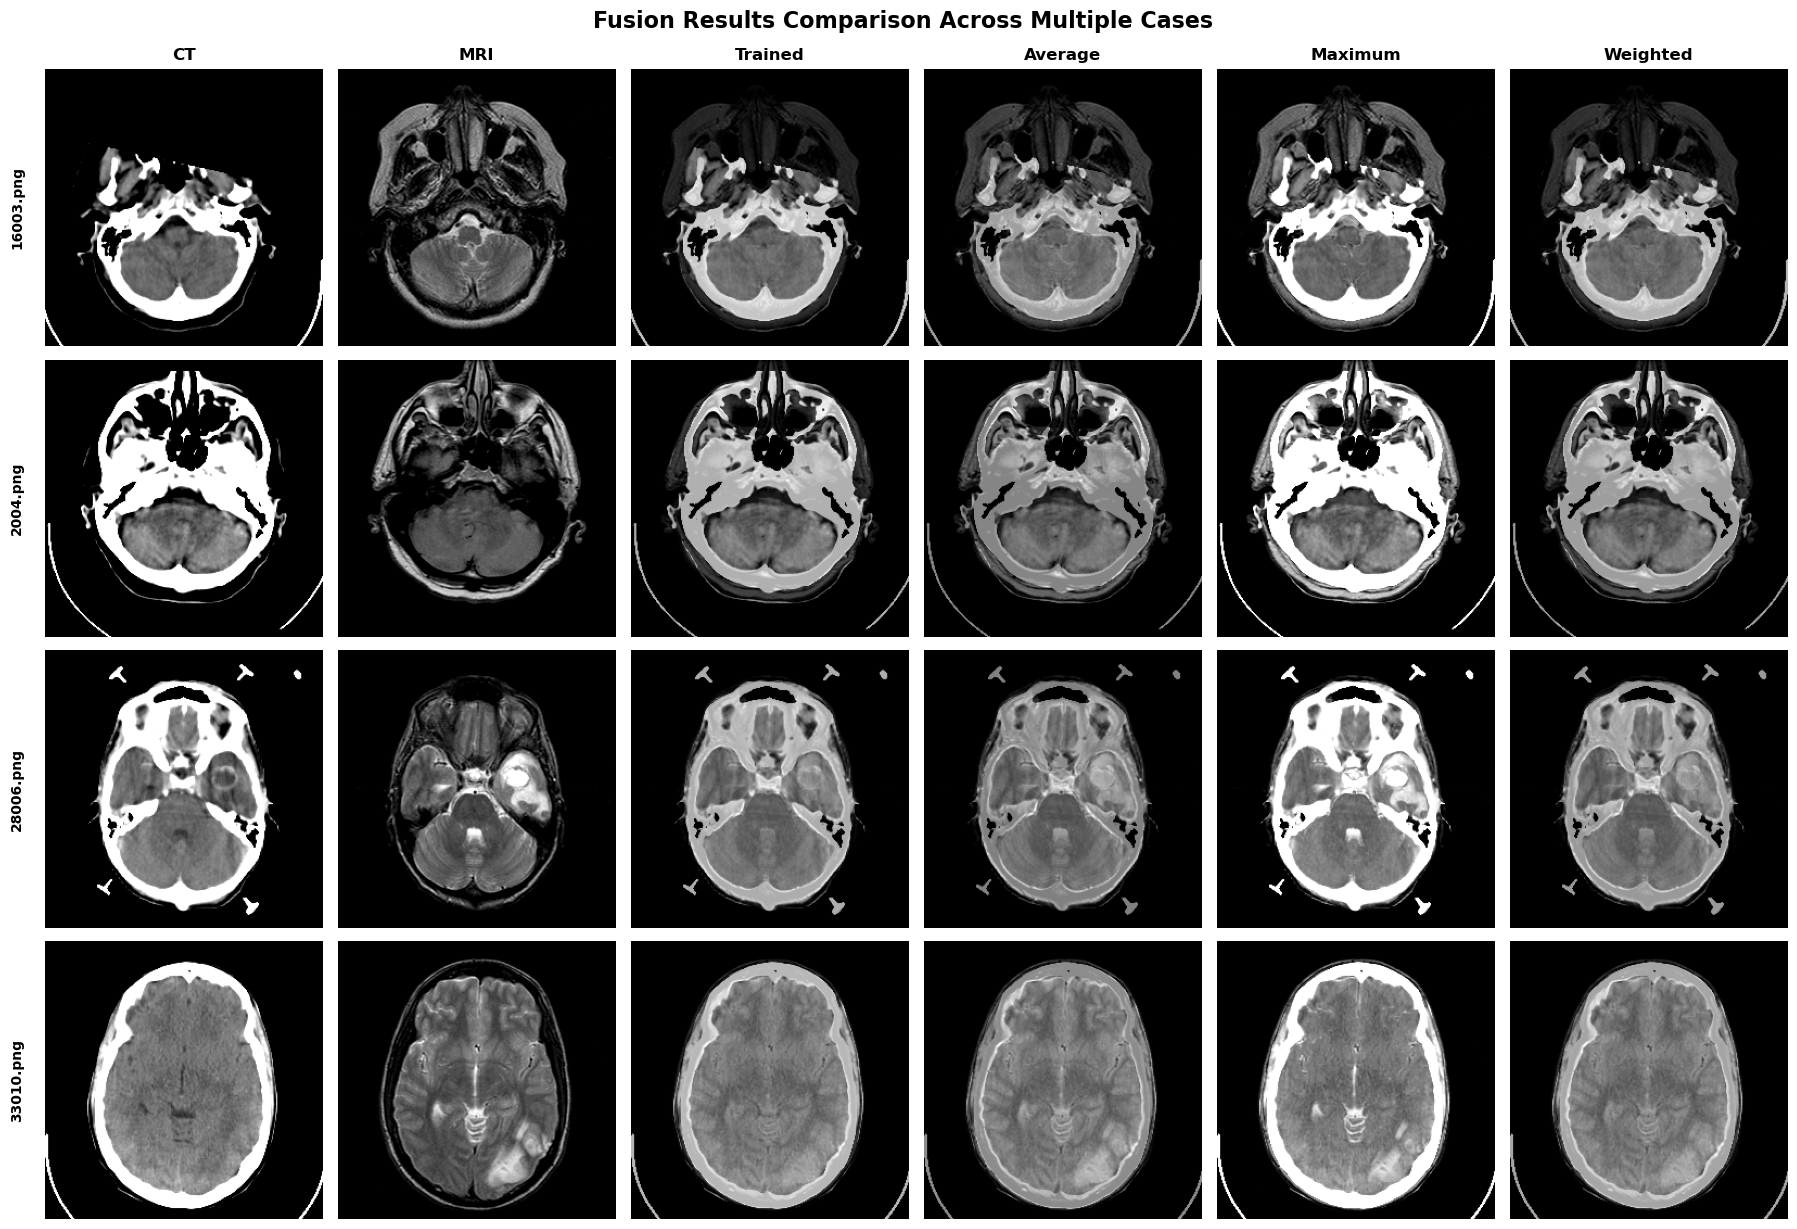

In [9]:
def display_multiple_cases(test_pairs, model, max_cases=4):
    """Display fusion results for multiple test cases."""
    n_cases = min(len(test_pairs), max_cases)
    
    fig, axes = plt.subplots(n_cases, 6, figsize=(18, 3*n_cases))
    if n_cases == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_cases):
        ct_path, mri_path = test_pairs[i]
        ct_img, mri_img = load_image_pair(ct_path, mri_path)
        
        # Generate fusions
        fused_model = fuse_with_model(model, ct_img, mri_img)
        fused_avg = fuse_average(ct_img, mri_img)
        fused_max = fuse_max(ct_img, mri_img)
        fused_weighted = fuse_weighted(ct_img, mri_img)
        
        # Display images
        images = [ct_img, mri_img, fused_model, fused_avg, fused_max, fused_weighted]
        titles = ['CT', 'MRI', 'Trained', 'Average', 'Maximum', 'Weighted']
        
        for j, (img, title) in enumerate(zip(images, titles)):
            if img is not None:
                axes[i, j].imshow(img, cmap='gray')
            else:
                axes[i, j].text(0.5, 0.5, 'N/A', ha='center', va='center')
            
            if i == 0:  # Add titles only to the first row
                axes[i, j].set_title(title, fontsize=12, fontweight='bold')
            axes[i, j].axis('off')
        
        # Add image name as row label
        axes[i, 0].text(-0.1, 0.5, os.path.basename(ct_path), 
                       transform=axes[i, 0].transAxes, rotation=90, 
                       ha='center', va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    return fig

# Display multiple test cases
if test_pairs and model is not None and len(test_pairs) > 0:
    fig = display_multiple_cases(test_pairs, model, max_cases=min(4, len(test_pairs)))
    plt.suptitle('Fusion Results Comparison Across Multiple Cases', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()

## 8. Visualize Metrics Summary

Create comprehensive visualizations and statistical summaries of the performance metrics.

Summary Statistics by Method:

SSIM_Avg:
                 mean     std     min     max
Method                                       
Average        0.7338  0.0843  0.6682  0.8872
Maximum        0.7544  0.0757  0.6887  0.9002
Trained Model  0.7392  0.0865  0.6637  0.8933
Weighted       0.7371  0.0855  0.6666  0.8908

PSNR_Avg:
                  mean     std      min        max
Method                                            
Average        14.9358  1.2126  13.2499  16.268200
Maximum        15.3345  3.8864  11.7915  22.710100
Trained Model  15.4785  1.2140  13.7912  16.814699
Weighted       15.1131  1.2126  13.4272  16.445499

Edge_Preservation:
                 mean     std     min     max
Method                                       
Average        0.9675  0.0186  0.9380  0.9947
Maximum        0.9293  0.0202  0.9114  0.9605
Trained Model  0.9639  0.0137  0.9442  0.9819
Weighted       0.9700  0.0143  0.9484  0.9893

Entropy:
                 mean     std     min     max
Method        

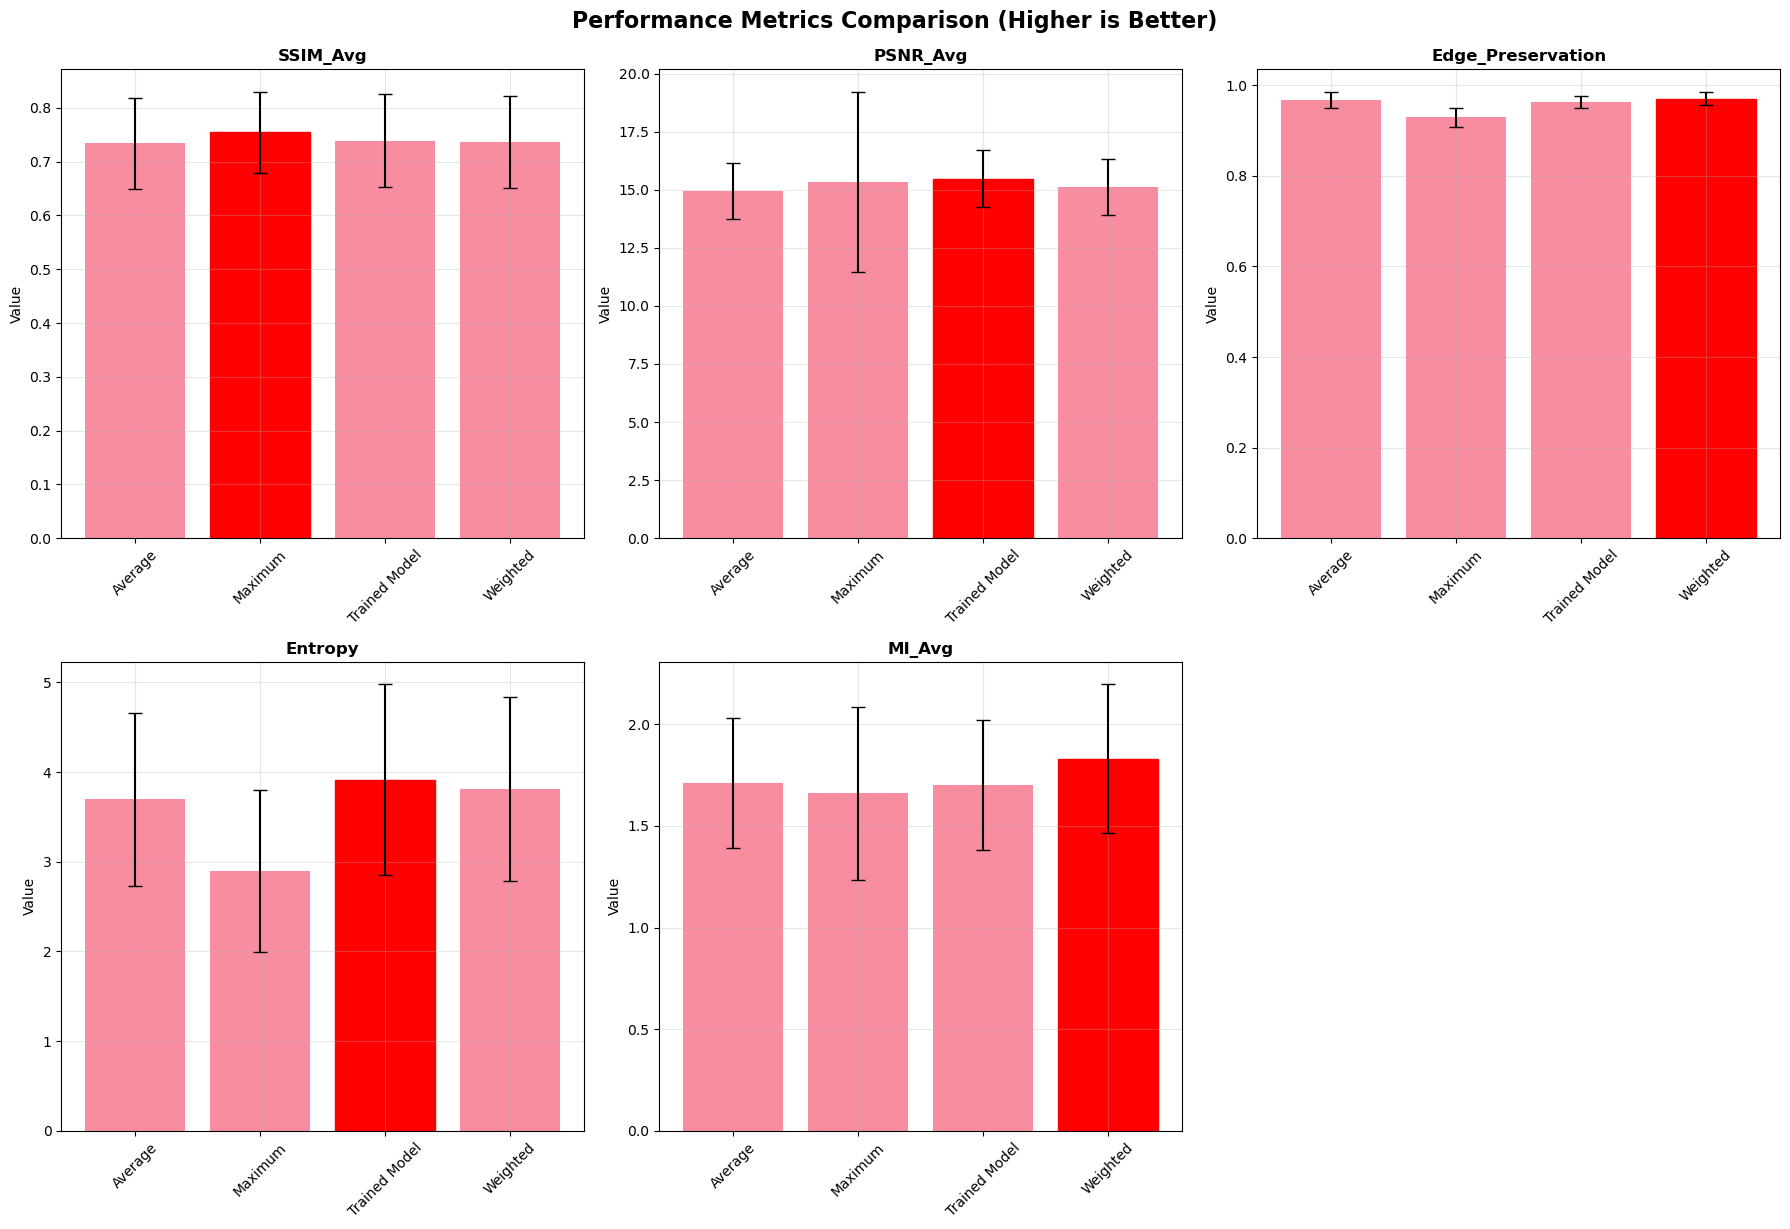

In [10]:
if not results_df.empty:
    # Create summary statistics
    metric_columns = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
    summary_stats = results_df.groupby('Method')[metric_columns].agg(['mean', 'std', 'min', 'max'])
    
    print("Summary Statistics by Method:")
    print("=" * 80)
    for metric in metric_columns:
        print(f"\n{metric}:")
        print(summary_stats[metric].round(4))
    
    # Visualization 1: Bar plot comparing average metrics
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metric_columns):
        if i < len(axes):
            mean_values = results_df.groupby('Method')[metric].mean()
            std_values = results_df.groupby('Method')[metric].std()
            
            bars = axes[i].bar(mean_values.index, mean_values.values, 
                              yerr=std_values.values, capsize=5, alpha=0.8)
            axes[i].set_title(f'{metric}', fontsize=12, fontweight='bold')
            axes[i].set_ylabel('Value')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(True, alpha=0.3)
            
            # Highlight the best method
            best_idx = mean_values.argmax()
            bars[best_idx].set_color('red')
            bars[best_idx].set_alpha(1.0)
    
    # Hide the last subplot if we have an odd number of metrics
    if len(metric_columns) < len(axes):
        axes[-1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Performance Metrics Comparison (Higher is Better)', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()
    
else:
    print("No results data available for visualization.")

### Heatmap of Performance Metrics

In [ ]:
if not results_df.empty:
    # Create a pivot table for heatmap
    pivot_data = results_df.pivot_table(index='Method', 
                                        columns='Image', 
                                        values='SSIM_Avg', 
                                        aggfunc='mean')
    
    # Create heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.3f', 
                cbar_kws={'label': 'Average SSIM'})
    plt.title('SSIM Performance Heatmap Across Test Images', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Test Images')
    plt.ylabel('Fusion Methods')
    plt.tight_layout()
    plt.show()
    
    # Box plots for metric distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    key_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy']
    
    for i, metric in enumerate(key_metrics):
        sns.boxplot(data=results_df, x='Method', y=metric, ax=axes[i])
        axes[i].set_title(f'{metric} Distribution', fontweight='bold')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Metric Distributions Across All Test Cases', 
                fontsize=16, fontweight='bold', y=1.02)
    plt.show()

### Ranking and Final Summary


FINAL RANKING - OVERALL PERFORMANCE

1. Weighted (Score: 0.5745)
   • SSIM Average:        0.7371 ± 0.0855
   • PSNR Average:        15.1131 ± 1.2126
   • Edge Preservation:   0.9700 ± 0.0143
   • Entropy:             3.8082 ± 1.0241
   • Mutual Information:  1.8304 ± 0.3671

2. Trained Model (Score: 0.5538)
   • SSIM Average:        0.7392 ± 0.0865
   • PSNR Average:        15.4785 ± 1.2140
   • Edge Preservation:   0.9639 ± 0.0137
   • Entropy:             3.9161 ± 1.0635
   • Mutual Information:  1.7008 ± 0.3191

3. Average (Score: 0.5369)
   • SSIM Average:        0.7338 ± 0.0843
   • PSNR Average:        14.9358 ± 1.2126
   • Edge Preservation:   0.9675 ± 0.0186
   • Entropy:             3.6940 ± 0.9674
   • Mutual Information:  1.7095 ± 0.3205

4. Maximum (Score: 0.4173)
   • SSIM Average:        0.7544 ± 0.0757
   • PSNR Average:        15.3345 ± 3.8864
   • Edge Preservation:   0.9293 ± 0.0202
   • Entropy:             2.9006 ± 0.9043
   • Mutual Information:  1.6601 ± 0.4262


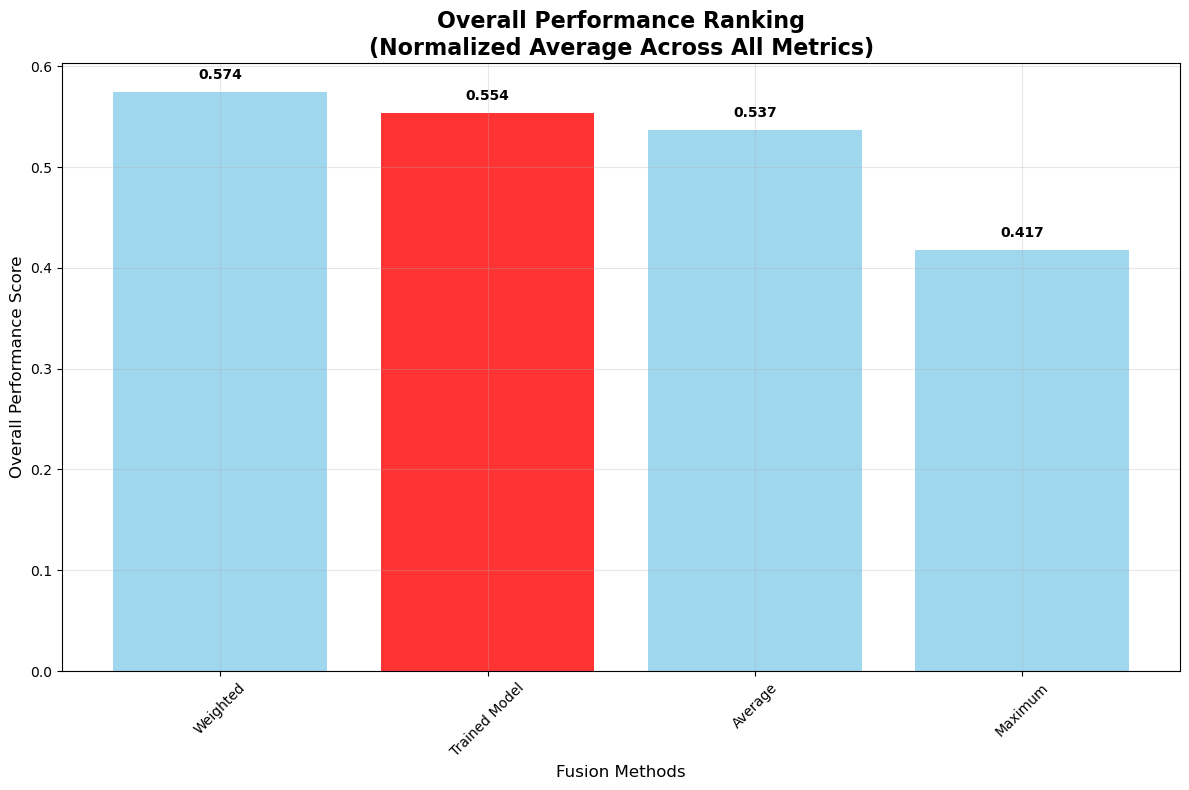


EVALUATION COMPLETE
Total test cases processed: 6
Fusion methods compared: 4
Trained model ranking: #2 out of 4


In [11]:
if not results_df.empty:
    # Calculate overall ranking
    ranking_metrics = ['SSIM_Avg', 'PSNR_Avg', 'Edge_Preservation', 'Entropy', 'MI_Avg']
    method_scores = {}
    
    for method in results_df['Method'].unique():
        method_data = results_df[results_df['Method'] == method]
        
        # Calculate normalized scores (0-1) for each metric
        scores = []
        for metric in ranking_metrics:
            if metric in method_data.columns:
                # Normalize by the maximum value across all methods
                max_val = results_df[metric].max()
                min_val = results_df[metric].min()
                if max_val > min_val:
                    normalized = (method_data[metric].mean() - min_val) / (max_val - min_val)
                else:
                    normalized = 1.0
                scores.append(normalized)
        
        method_scores[method] = np.mean(scores)
    
    # Sort methods by overall score
    ranked_methods = sorted(method_scores.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "="*60)
    print("FINAL RANKING - OVERALL PERFORMANCE")
    print("="*60)
    
    for i, (method, score) in enumerate(ranked_methods, 1):
        method_data = results_df[results_df['Method'] == method]
        print(f"\n{i}. {method} (Score: {score:.4f})")
        print(f"   • SSIM Average:        {method_data['SSIM_Avg'].mean():.4f} ± {method_data['SSIM_Avg'].std():.4f}")
        print(f"   • PSNR Average:        {method_data['PSNR_Avg'].mean():.4f} ± {method_data['PSNR_Avg'].std():.4f}")
        print(f"   • Edge Preservation:   {method_data['Edge_Preservation'].mean():.4f} ± {method_data['Edge_Preservation'].std():.4f}")
        print(f"   • Entropy:             {method_data['Entropy'].mean():.4f} ± {method_data['Entropy'].std():.4f}")
        print(f"   • Mutual Information:  {method_data['MI_Avg'].mean():.4f} ± {method_data['MI_Avg'].std():.4f}")
    
    # Create a final comparison chart
    plt.figure(figsize=(12, 8))
    methods = [item[0] for item in ranked_methods]
    scores = [item[1] for item in ranked_methods]
    colors = ['red' if 'Trained' in method else 'skyblue' for method in methods]
    
    bars = plt.bar(methods, scores, color=colors, alpha=0.8)
    plt.title('Overall Performance Ranking\n(Normalized Average Across All Metrics)', 
              fontsize=16, fontweight='bold')
    plt.ylabel('Overall Performance Score', fontsize=12)
    plt.xlabel('Fusion Methods', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("EVALUATION COMPLETE")
    print("="*60)
    print(f"Total test cases processed: {len(test_pairs)}")
    print(f"Fusion methods compared: {len(ranked_methods)}")
    if 'Trained Model' in method_scores:
        trained_rank = next(i for i, (method, _) in enumerate(ranked_methods, 1) if method == 'Trained Model')
        print(f"Trained model ranking: #{trained_rank} out of {len(ranked_methods)}")
    
else:
    print("No results available for final analysis.")